In [1]:
from spectacle.core.spectra import Spectrum1D
from spectacle.process.lsf import LSF
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from spectacle.modeling.fitting import LevMarFitter
from astropy.modeling.models import Linear1D
from spectacle.core.models import Voigt1D

from uncertainties import unumpy as unp

In [2]:
%matplotlib inline
plt.rcParams["figure.figsize"] = [16, 8]

# Identify and parameterize real data
This is an example notebook of taking some real data and fitting an absorption feature. It is very basic, and uses all the default settings.

## Load data
Load the data. The fitter currently assumes that all data has been normalized to 1.

In [3]:
# Load real data
with fits.open("/Users/nearl/projects/hst_proposal/QSOALS/3C066A/3C066A_coadd_FUVM_final_all.fits") as hdulist:
    disp, flux, uncert, dq = hdulist[1].data['WAVE'], hdulist[1].data['FLUX'], \
                             hdulist[1].data['ERROR'], hdulist[1].data['DQ']


<Container object of 3 artists>

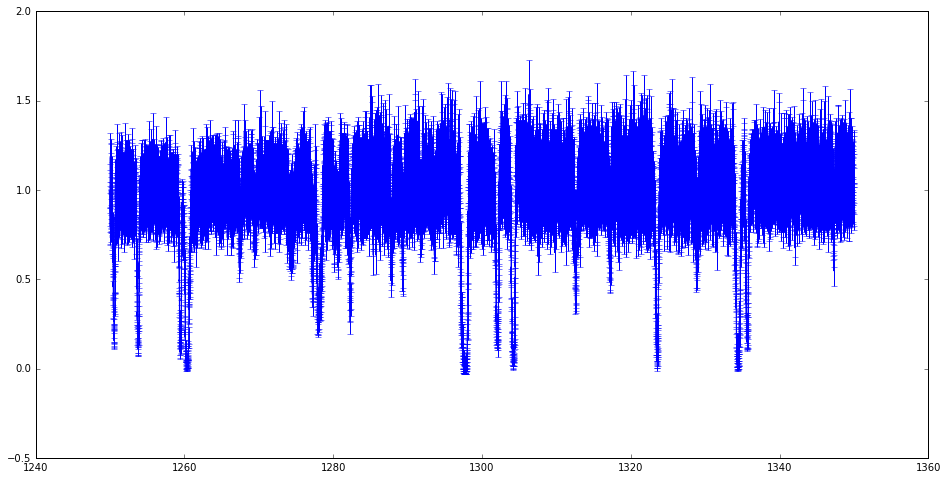

In [4]:
# Create a mask and apply it since we don't really care about the entire spectrum
mask = [(disp > 1250) & (disp < 1350)]
# mask = [(disp > 1290) & (disp < 1300)]

flux = flux[mask]
disp = disp[mask]
uncert = uncert[mask]

# Currently, the fitting assumes that the data is normalized to 1.0
tmp_flux = unp.uarray(flux, uncert)
tmp_flux /= np.median(tmp_flux)
flux, uncert = unp.nominal_values(tmp_flux), unp.std_devs(tmp_flux)

# Create spectrum object
spectrum = Spectrum1D(disp, flux, uncertainty=uncert)

# Plot the spectrum
plt.errorbar(spectrum.dispersion, spectrum.flux, yerr=spectrum.uncertainty)
# plt.plot(spectrum.dispersion, spectrum.flux)

## Create `Fitter`
The `Fitter` object encapsulates the method of fitting, along with the line identifying and detrending routines. Certain parameters, like the distance between identified lines, and the noise level can also be set.

/Users/nearl/anaconda3/envs/spec_env/lib/python3.5/site-packages/spectacle/core/models.py:70: RuntimeWarning: overflow encountered in exp
  flux = np.exp(-profile.optical_depth) - 1.0
/Users/nearl/anaconda3/envs/spec_env/lib/python3.5/site-packages/scipy/optimize/minpack.py:458: RuntimeWarning: overflow encountered in multiply
  return weights * (func(xdata, *params) - ydata)


    Parameter     Original Value   Fitted Value   Uncertainty
----------------- -------------- ---------------- -----------
          slope_0            0.0              0.0         0.0
      intercept_0            1.0              1.0         0.0
       lambda_0_1   1250.5471819    1248.06880301         inf
        f_value_1       0.005453 -0.0160798557618         inf
          gamma_1     46300000.0       46300000.0         0.0
      v_doppler_1     10000000.0    5839961.21747         inf
 column_density_1          1e+14    10000000000.0         inf
       lambda_0_2  1253.78551788    1252.78289935         inf
        f_value_2        0.01088   0.674048102014         inf
          gamma_2     46200000.0       46200000.0         0.0
              ...            ...              ...         ...
column_density_17          1e+14 2.7795384386e+14         inf
      lambda_0_18  1335.60083086    1331.70018797         inf
       f_value_18        0.01277   0.366945921641         inf
        

/Users/nearl/anaconda3/envs/spec_env/lib/python3.5/site-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


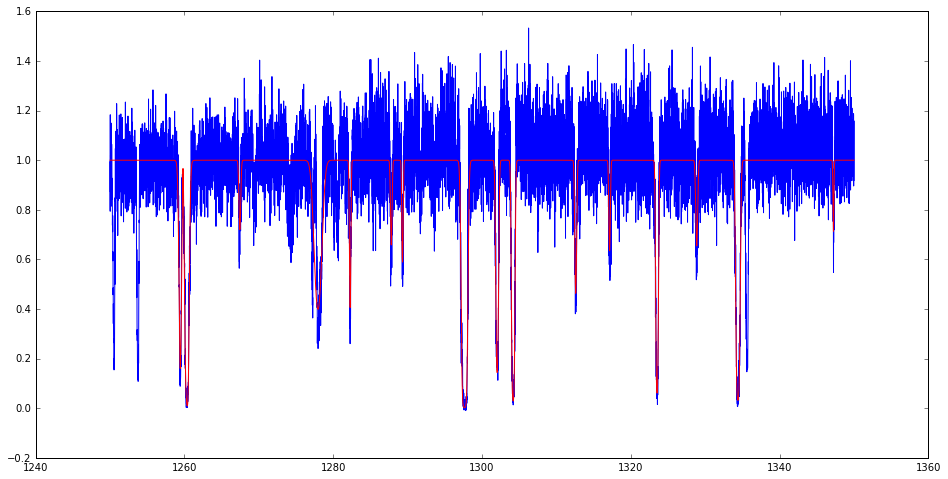

In [7]:
# Create a fitter. The default fitting routine is a LevMarLSQ.
fitter = LevMarFitter(noise=2.75)
result_spectrum = fitter(spectrum)
print(fitter.fit_info)

# Plot the fitted spectrum with the original
plt.errorbar(spectrum.dispersion, spectrum.flux)
plt.plot(result_spectrum.dispersion, result_spectrum.flux, color='red')

Let's get some first- and second-order information out of this.

In [6]:
print("Equivalent width: {}".format(result_spectrum.equivalent_width()))
print("FWHM: {}".format(result_spectrum.fwhm(1356)))
print("Optical Depth: {}".format(result_spectrum.optical_depth(1356)))
print("Centroid: {}".format(result_spectrum.centroid(1356)))

Equivalent width: (5.659155362923858, 0.0)
FWHM: 576001757.450191
Optical Depth: (array(8.247860809476797e-08), array(0.0))
Centroid: (array(1300.2930635724433), array(0.0))
